In [1]:
cleaned_expression_data = [line.strip().split("\t") for line in open("../gold_standard_sentences/clean_with_negative_otherexpr.csv")]
cleaned_kinaseact_data = [line.strip().split("\t") for line in open("../gold_standard_sentences/clean_with_negative_kinaseact.csv")]
cleaned_expression_data = [[row[0], int(row[1]), row[2]] for row in cleaned_expression_data]
cleaned_kinaseact_data = [[row[0], int(row[1]), row[2]] for row in cleaned_kinaseact_data]

In [2]:
from sentence_transformers import SentenceTransformer

embedder = SentenceTransformer('all-MiniLM-L6-v2')

In [3]:
corpus_expr = embedder.encode([row[0] for row in cleaned_expression_data], convert_to_tensor=True)
corpus_kinaseact = embedder.encode([row[0] for row in cleaned_kinaseact_data], convert_to_tensor=True)

In [4]:
import umap

umap_reducer = umap.UMAP(metric='cosine')
corpus_expr_2d = umap_reducer.fit_transform(corpus_expr)
corpus_kinaseact_2d = umap_reducer.fit_transform(corpus_kinaseact)

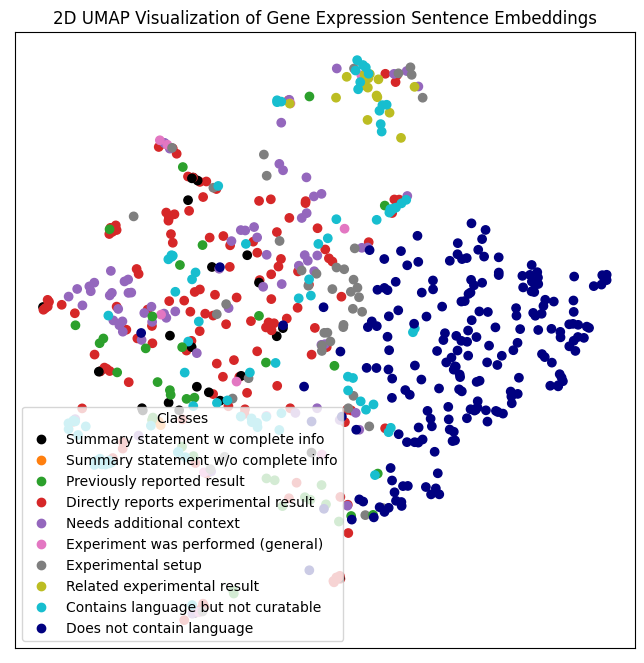

In [7]:
from matplotlib.colors import ListedColormap
from matplotlib import pyplot as plt

colors = ListedColormap(['black','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:grey','tab:olive','tab:cyan', 'navy'])
values = [int(row[1]) for row in cleaned_expression_data]
classes = ['Summary statement w complete info', 'Summary statement w/o complete info', 'Previously reported result', 'Directly reports experimental result', 'Needs additional context', 'Experiment was performed (general)', 'Experimental setup', 'Related experimental result', 'Contains language but not curatable', 'Does not contain language']
fig, ax = plt.subplots(figsize=(8,8))
scatter = ax.scatter(x=list(corpus_expr_2d[:,0]), y=list(corpus_expr_2d[:,1]), c=values, cmap=colors)
plt.xticks([])
plt.yticks([])
plt.title("2D UMAP Visualization of Gene Expression Sentence Embeddings")
legend = ax.legend(handles=scatter.legend_elements()[0], loc="lower left", title="Classes", labels=classes)

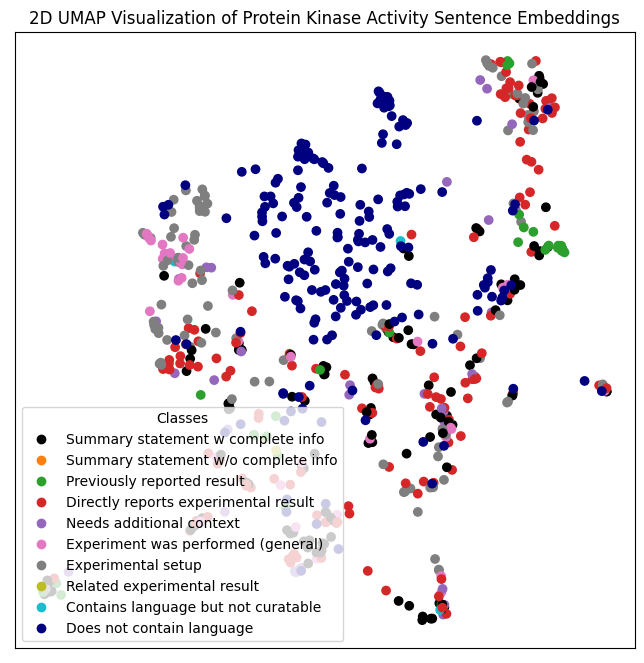

In [8]:
values = [int(row[1]) for row in cleaned_kinaseact_data]
fig, ax = plt.subplots(figsize=(8, 8))
plt.xticks([])
plt.yticks([])
plt.title("2D UMAP Visualization of Protein Kinase Activity Sentence Embeddings")
ax.scatter(x=list(corpus_kinaseact_2d[:,0]), y=list(corpus_kinaseact_2d[:,1]), c=values, cmap=colors)
legend = ax.legend(handles=scatter.legend_elements()[0], loc="lower left", title="Classes", labels=classes)

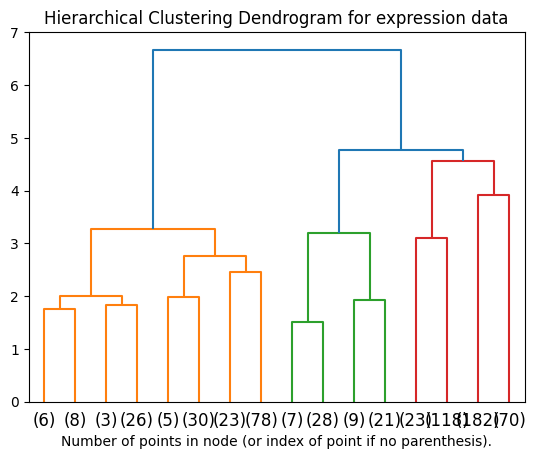

In [9]:
from sentence_classification.clustering import plot_dendrogram
from matplotlib import pyplot as plt
from sklearn.cluster import AgglomerativeClustering

X_expr = corpus_expr

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0.2, n_clusters=None)

model_expr = model.fit(X_expr)
plt.title("Hierarchical Clustering Dendrogram for expression data")
# plot the top three levels of the dendrogram
plot_dendrogram(model_expr, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

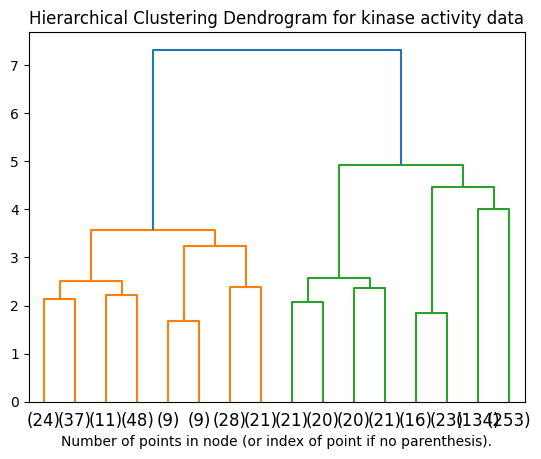

In [10]:
X_kinaseact = corpus_kinaseact

model_kinaseact = model.fit(X_kinaseact)
plt.title("Hierarchical Clustering Dendrogram for kinase activity data")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

# classifiers

In [11]:
from random import shuffle
from sklearn.neural_network import MLPClassifier
import math

converted_corpus_expr = corpus_expr.numpy()
converted_corpus_kinaseact = corpus_kinaseact.numpy()
indices_expr = [i for i in range(len(corpus_expr))]
shuffle(indices_expr)
training_size_expr = math.ceil(len(corpus_expr) * 0.8)
training_indices_expr = indices_expr[0:training_size_expr]
test_indices_expr = indices_expr[training_size_expr:]
training_set_data_expr = [converted_corpus_expr[index] for index in training_indices_expr]
test_set_classes_expr = [cleaned_expression_data[index][1] for index in test_indices_expr]
indices_kinaseact = [i for i in range(len(corpus_kinaseact))]
shuffle(indices_kinaseact)
training_size_kinaseact = math.ceil(len(corpus_kinaseact) * 0.8)
training_indices_kinaseact = indices_kinaseact[0:training_size_kinaseact]
test_indices_kinaseact = indices_kinaseact[training_size_kinaseact:]
training_set_data_kinaseact = [converted_corpus_kinaseact[index] for index in training_indices_kinaseact]
test_set_classes_kinaseact = [cleaned_kinaseact_data[index][1] for index in test_indices_kinaseact]
base_clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)

# prediction
## multiclass

In [12]:
from sklearn.metrics import precision_recall_fscore_support as score
training_set_classes_expr = [cleaned_expression_data[index][1] for index in training_indices_expr]
test_set_data_expr = [converted_corpus_expr[index] for index in test_indices_expr]
clf = base_clf.fit(training_set_data_expr, training_set_classes_expr)
test_predictions_expr = list(clf.predict(test_set_data_expr))
precision, recall, fscore, support = score(test_set_classes_expr, test_predictions_expr)
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.         0.         0.         0.30882353 0.18181818 0.
 0.3125     0.         0.         0.96551724]
recall: [0.         0.         0.         0.75       0.11111111 0.
 0.55555556 0.         0.         0.90322581]
fscore: [0.         0.         0.         0.4375     0.13793103 0.
 0.4        0.         0.         0.93333333]
support: [ 6  1  6 28 18  2  9  5 21 31]


/home/valerio/workspace/caltech/sentence_classification/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/valerio/workspace/caltech/sentence_classification/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [13]:
training_set_classes_kinaseact = [cleaned_kinaseact_data[index][1] for index in training_indices_kinaseact]
test_set_data_kinaseact = [converted_corpus_kinaseact[index] for index in test_indices_kinaseact]
clf = base_clf.fit(training_set_data_kinaseact, training_set_classes_kinaseact)
test_predictions_kinaseact = list(clf.predict(test_set_data_kinaseact))
precision, recall, fscore, support = score(test_set_classes_kinaseact, test_predictions_kinaseact)
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.41935484 0.         0.64516129 0.         0.1        0.34782609
 0.         0.         0.88372093]
recall: [0.46428571 0.         0.74074074 0.         0.125      0.36363636
 0.         0.         0.84444444]
fscore: [0.44067797 0.         0.68965517 0.         0.11111111 0.35555556
 0.         0.         0.86363636]
support: [28  4 27  3  8 22  1  1 45]


/home/valerio/workspace/caltech/sentence_classification/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/valerio/workspace/caltech/sentence_classification/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## binary
### 1. Classifier that extracts sentences that contain all the information necessary to make an annotation.

In [14]:
training_set_classes_expr = [1 if cleaned_expression_data[index][1] in [0, 3] else 0 for index in training_indices_expr]
test_set_classes_expr = [1 if cleaned_expression_data[index][1] in [0, 3] else 0 for index in test_indices_expr]
clf = base_clf.fit(training_set_data_expr, training_set_classes_expr)

test_predictions_expr = list(clf.predict(test_set_data_expr))
precision, recall, fscore, support = score(test_set_classes_expr, test_predictions_expr)
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.83673469 0.62068966]
recall: [0.88172043 0.52941176]
fscore: [0.85863874 0.57142857]
support: [93 34]


In [25]:
precision, recall, fscore, support = score(test_set_classes_expr, test_predictions_expr, average='binary')
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: 0.803921568627451
recall: 0.7735849056603774
fscore: 0.7884615384615384
support: None


In [17]:
training_set_classes_kinaseact = [1 if cleaned_kinaseact_data[index][1] in [0, 3] and cleaned_kinaseact_data[index][2] in ['positive', 'both'] else 0 for index in training_indices_kinaseact]
test_set_classes_kinaseact = [1 if cleaned_kinaseact_data[index][1] in [0, 3] and cleaned_kinaseact_data[index][2] in ['positive', 'both'] else 0 for index in test_indices_kinaseact]
clf = base_clf.fit(training_set_data_kinaseact, training_set_classes_kinaseact)
test_predictions_kinaseact = list(clf.predict(test_set_data_kinaseact))
precision, recall, fscore, support = score(test_set_classes_kinaseact, test_predictions_kinaseact)
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.86046512 0.71698113]
recall: [0.83146067 0.76      ]
fscore: [0.84571429 0.73786408]
support: [89 50]


In [18]:
precision, recall, fscore, support = score(test_set_classes_kinaseact, test_predictions_kinaseact, average="binary")
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: 0.7169811320754716
recall: 0.76
fscore: 0.7378640776699028
support: None


### 2. Classifier that extracts sentences that contain curatable information

In [19]:
training_set_classes_expr = [1 if cleaned_expression_data[index][1] in [0, 1, 3, 4] else 0 for index in training_indices_expr]
test_set_classes_expr = [1 if cleaned_expression_data[index][1] in [0, 1, 3, 4] else 0 for index in test_indices_expr]
clf = base_clf.fit(training_set_data_expr, training_set_classes_expr)

test_predictions_expr = list(clf.predict(test_set_data_expr))
precision, recall, fscore, support = score(test_set_classes_expr, test_predictions_expr)
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.84210526 0.80392157]
recall: [0.86486486 0.77358491]
fscore: [0.85333333 0.78846154]
support: [74 53]


In [20]:
precision, recall, fscore, support = score(test_set_classes_expr, test_predictions_expr, average="binary")
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))


precision: 0.803921568627451
recall: 0.7735849056603774
fscore: 0.7884615384615384
support: None


In [31]:
training_set_classes_kinaseact = [1 if cleaned_kinaseact_data[index][1] in [0, 1, 3, 4] and cleaned_kinaseact_data[index][2] in ['positive', 'both'] else 0 for index in training_indices_kinaseact]
test_set_classes_kinaseact = [1 if cleaned_kinaseact_data[index][1] in [0, 1, 3, 4] and cleaned_kinaseact_data[index][2] in ['positive', 'both'] else 0 for index in test_indices_kinaseact]
clf = base_clf.fit(training_set_data_kinaseact, training_set_classes_kinaseact)

test_predictions_kinaseact = list(clf.predict(test_set_data_kinaseact))
precision, recall, fscore, support = score(test_set_classes_kinaseact, test_predictions_kinaseact)
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.84146341 0.70175439]
recall: [0.80232558 0.75471698]
fscore: [0.82142857 0.72727273]
support: [86 53]


/home/valerio/workspace/caltech/sentence_classification/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [22]:
precision, recall, fscore, support = score(test_set_classes_kinaseact, test_predictions_kinaseact, average="weighted")
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: 0.7881930655732152
recall: 0.7841726618705036
fscore: 0.7855274222180697
support: None


### 3. Classifier that extracts sentences that contain language

In [29]:
training_set_classes_expr = [1 if cleaned_expression_data[index][1] < 9 else 0 for index in training_indices_expr]
test_set_classes_expr = [1 if cleaned_expression_data[index][1] < 9 else 0 for index in test_indices_expr]
clf = base_clf.fit(training_set_data_expr, training_set_classes_expr)

test_predictions_expr = list(clf.predict(test_set_data_expr))
precision, recall, fscore, support = score(test_set_classes_expr, test_predictions_expr)
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.9375     0.98947368]
recall: [0.96774194 0.97916667]
fscore: [0.95238095 0.98429319]
support: [31 96]


In [30]:
precision, recall, fscore, support = score(test_set_classes_expr, test_predictions_expr, average="binary")
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: 0.9894736842105263
recall: 0.9791666666666666
fscore: 0.9842931937172775
support: None


In [32]:
training_set_classes_kinaseact = [1 if cleaned_kinaseact_data[index][1] < 9 and cleaned_kinaseact_data[index][2] in ['positive', 'both'] else 0 for index in training_indices_kinaseact]
test_set_classes_kinaseact = [1 if cleaned_kinaseact_data[index][1] < 9 and cleaned_kinaseact_data[index][2] in ['positive', 'both'] else 0 for index in test_indices_kinaseact]
clf = base_clf.fit(training_set_data_kinaseact, training_set_classes_kinaseact)

test_predictions_kinaseact = list(clf.predict(test_set_data_kinaseact))
precision, recall, fscore, support = score(test_set_classes_kinaseact, test_predictions_kinaseact)
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.89189189 0.78461538]
recall: [0.825      0.86440678]
fscore: [0.85714286 0.82258065]
support: [80 59]


/home/valerio/workspace/caltech/sentence_classification/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [33]:
precision, recall, fscore, support = score(test_set_classes_kinaseact, test_predictions_kinaseact, average="weighted")
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: 0.8463572593068996
recall: 0.841726618705036
fscore: 0.842472565726221
support: None


# Feature analysis for positive sentences

## expression

(0.0, 210.0)

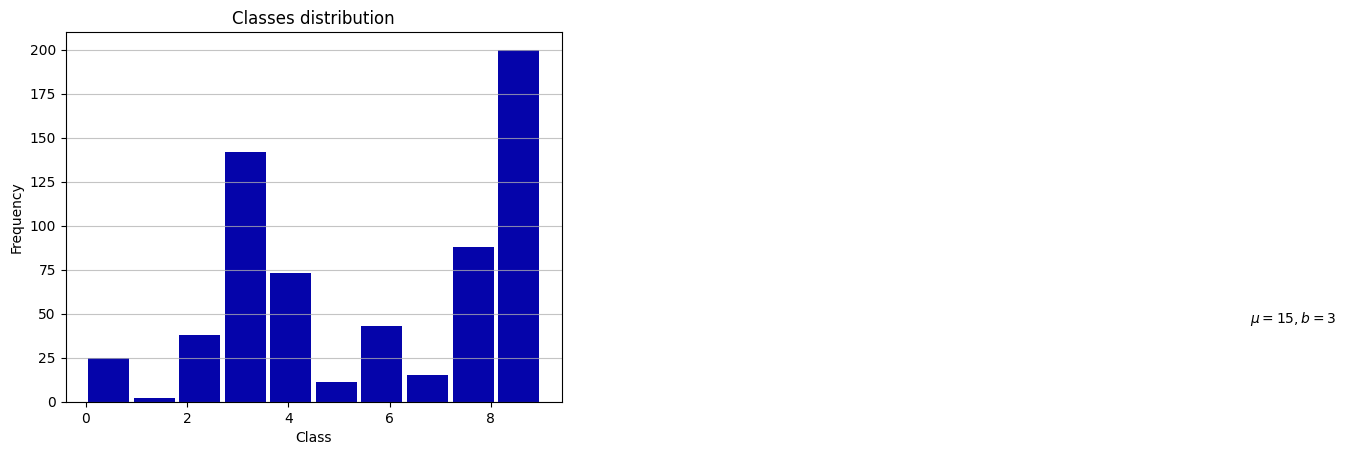

In [23]:
import matplotlib.pyplot as plt
import numpy as np

n, bins, patches = plt.hist(x=[r[1] for r in cleaned_expression_data], bins=10, color='#0504aa',
                            alpha=1, rwidth=0.9)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Classes distribution')
plt.text(23, 45, r'$\mu=15, b=3$')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

# kinase act

(0.0, 210.0)

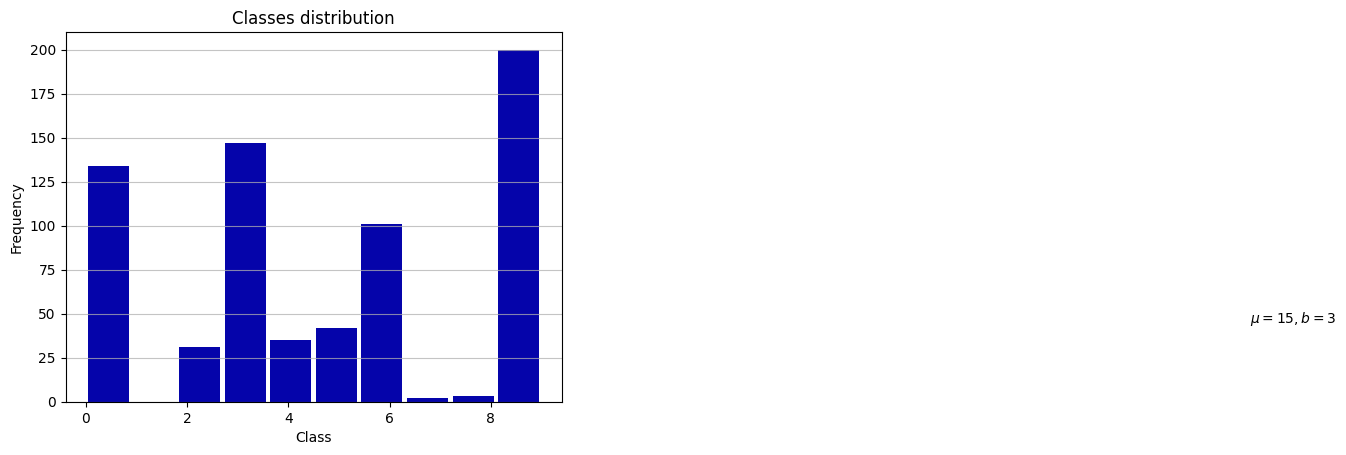

In [26]:
n, bins, patches = plt.hist(x=[r[1] for r in cleaned_kinaseact_data], bins=10, color='#0504aa',
                            alpha=1, rwidth=0.9)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Classes distribution')
plt.text(23, 45, r'$\mu=15, b=3$')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)